In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total, DATE_FORMAT, total_to_csv

from const import STATE, COLORS, NUM_STATES,  STATES


In [3]:
p0_time = pkl.load(open('output/p0_time.pkl', 'rb'))
lockdown_time = T('23/01/2020')
days_before_ld  = (lockdown_time -  p0_time).days
params_before = pkl.load(
    open('output/params_before_lockdown.pkl', 'rb')
)

params_after = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

bed_info = pkl.load(open('data/bed_info.pkl', 'rb'))

infection_factor = 1.999881671966743

In [16]:
event_date = T('20/01/2020')
days_before_event = (event_date - p0_time).days
days_before_event

52

In [29]:
total_days = 360

def one_run(event_factor):
    alpha_list = [
        (0, params_before.alpha),
        (days_before_event, event_factor * params_before.alpha),
        (days_before_ld, params_after.alpha)
    ]
    beta_list = [
        (0, params_before.beta),
        (days_before_event, params_before.beta),
        (days_before_ld, params_after.beta)
    ]

    p = Params(
        alpha=alpha_list,
        beta=beta_list,
        stages=[days_before_event, days_before_ld],
        initial_num_E=1,
        initial_num_I=0,
        initial_num_M=0
    )

    total, _, _, r0_info = do_simulation(total_days, bed_info, p)
    return event_factor, total, r0_info, p

In [30]:
factors = np.arange(1, 1.251, step=0.05)
#  factors = np.arange(1, 9, step=1)
rows = Parallel(n_jobs=-1)(delayed(one_run)(factor) for factor in factors)

factor = 1.0
[2.6491998707542876, 2.654211017368717, 1.9922981370692237]
factor = 1.05
[2.6491998707542876, 2.7326292496538804, 1.994736350068161]
factor = 1.1
[2.6491998707542876, 2.8109734923708922, 1.9968042635674756]
factor = 1.1500000000000001
[2.6491998707542876, 2.8892438757675594, 1.9989887625796385]
factor = 1.2000000000000002
[2.6491998707542876, 2.9674405297861544, 2.0010656557145405]
factor = 1.2500000000000002
[2.6491998707542876, 3.0455635840643165, 2.0030568868750387]


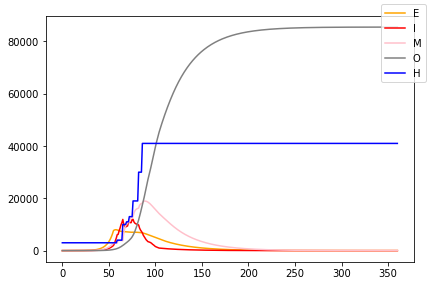

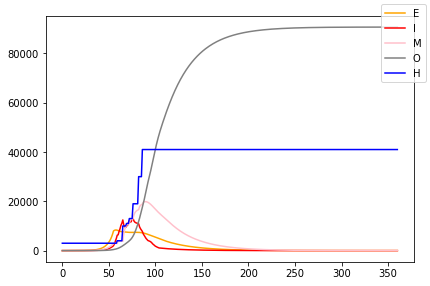

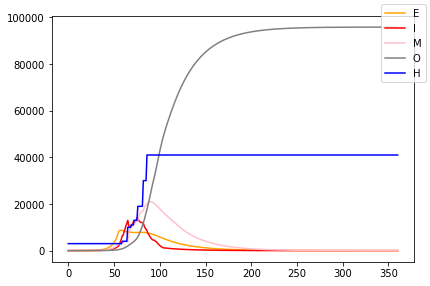

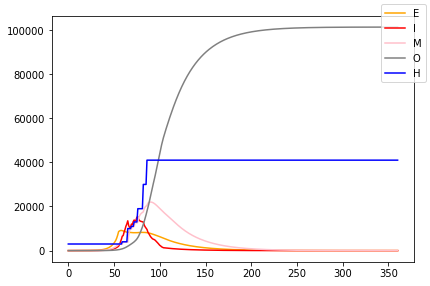

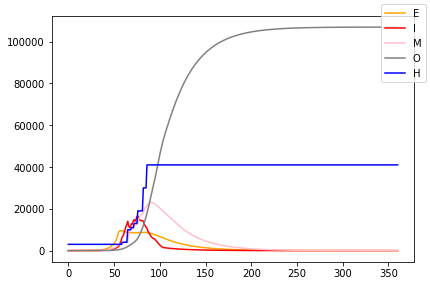

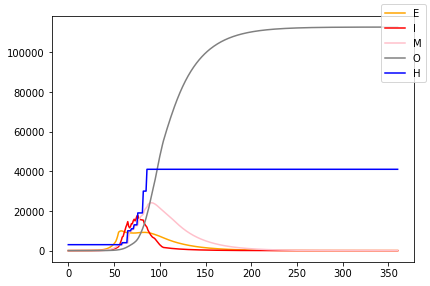

In [31]:
r0_rows = []
for event_factor, total, r0_info, p in rows:    
    print('factor =', event_factor)
    r0_row = [t[-1] for t in r0_info.values()]
    print(r0_row)
    r0_rows.append([event_factor] + r0_row)
    fig, ax = plot_total(total)
    fig.savefig(f'figs/public-event/{event_factor}.pdf')
    total_to_csv(p0_time, total_days, total, f'output/tbl/public-event/{event_factor}.csv')

In [32]:
df = pd.DataFrame(r0_rows, columns=['factor', 'before  event', 'after event', 'after lockdown'])
df
df.to_csv('output/tbl/public-event/r0.csv', index=None)